In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
import time
import matplotlib.pyplot as plt
import math

Reading csv files (may be changed to other paths)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/homedepot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('/content/drive/MyDrive/homedepot_data/test.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv('/content/drive/MyDrive/homedepot_data/attributes.csv')
df_pro_desc = pd.read_csv('/content/drive/MyDrive/homedepot_data/product_descriptions.csv')

# Analizing the data

In [ ]:
def total_num_pairs(df=df_train) -> str:
    pairs = df[['product_title', 'search_term']]
    unique_pairs = pairs.drop_duplicates()
    num_unique_pairs = unique_pairs.shape[0]
    return f'Number of unique product-query pairs:{num_unique_pairs}'
total_num_pairs()

'Number of unique product-query pairs:73392'

In [ ]:
def unique_products(df=df_train) -> str:
    num = df['product_title'].nunique()
    return f'Number of unique products: {num}'
unique_products()

'Number of unique products: 53489'

In [ ]:
def top_2_occur_product(df=df_train) -> str:
    product_counts = df['product_title'].value_counts()
    top_two_products = product_counts.head(2)
    return f'Top two occurring products and their counts in column:"\n{top_two_products}'
top_2_occur_product()

'Top two occurring products and their counts in column:"\nproduct_title\nLithonia Lighting All Season 4 ft. 2-Light Grey T8 Strip Fluorescent Shop Light                                          21\nPressure-Treated Timber #2 Southern Yellow Pine (Common: 4 in. x 4 in. x 8 ft.; Actual: 3.56 in. x 3.56 in. x 96 in.)    21\nName: count, dtype: int64'

In [ ]:
def relevance_mean(df=df_train) -> str:
    mean = df['relevance'].mean()
    return f'Mean: {mean}'
relevance_mean()

'Mean: 2.3816337910270433'

In [ ]:
def standard_dev(num: int = len(df_train['relevance']), points: list[float] = df_train['relevance'].tolist(),
                 mean: float = df_train['relevance'].mean()) -> str:
    variance = 0
    for point in points:
        variance += pow((point - mean), 2)
    return f'Standard deviation: {math.sqrt((variance / (num - 1)))}'
standard_dev()

'Standard deviation: 0.5339839484172103'

In [ ]:
def relevance_med(df=df_train) -> str:
    return f'Median: {df["relevance"].median()}'
relevance_med()

'Median: 2.33'

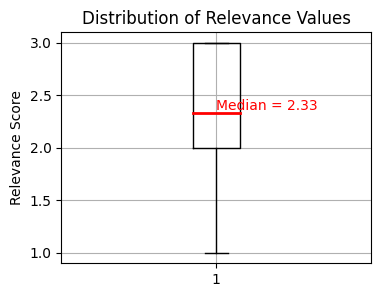

In [ ]:
def boxplot(df=df_train):
    relevance_values = df['relevance'].tolist()
    median_value = np.median(relevance_values)
    plt.figure(figsize=(4, 3))
    plt.boxplot(relevance_values, medianprops=dict(color='red', linewidth=2))
    plt.title('Distribution of Relevance Values')
    plt.ylabel('Relevance Score')
    plt.grid(True)
    plt.text(1, median_value, f'Median = {median_value:.2f}', ha='left', va='bottom', color='red')
    plt.show()
boxplot()

# Random Forest Regression

Baseline features \\
https://www.kaggle.com/code/wenxuanchen/sklearn-random-forest/script

In [ ]:
stemmer = SnowballStemmer('english')

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0],
                                                                                     x.split('\t')[2]))

df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

In [ ]:
y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values
X_test = df_test.drop(['id', 'relevance'], axis=1).values
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Import libraries for rmse score and splitting training set to 80% train -20% test

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
clf.fit(X_train_split, y_train_split)
y_pred_split = clf.predict(X_test_split)
rmse = np.sqrt(mean_squared_error(y_test_split, y_pred_split))
print("RMSE:", rmse)

RMSE: 0.4797667197056582


LastWordMatch

In [ ]:
num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

def last_word_match(search_term, product_title, product_description):
    last_word = search_term.split()[-1]
    title_words = product_title.split()
    description_words = product_description.split()
    if last_word in title_words or last_word in description_words:
        return 1
    else:
        return 0

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['last_word_match'] = df_all.apply(lambda row: last_word_match(row['search_term'], row['product_title'], row['product_description']), axis=1)

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values


In [ ]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
X_train_split_lwm, X_test_split_lwm, y_train_split_lwm, y_test_split_lwm = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
clf.fit(X_train_split_lwm, y_train_split_lwm)

y_pred_split_lwm = clf.predict(X_test_split_lwm)
rmse = np.sqrt(mean_squared_error(y_test_split_lwm, y_pred_split_lwm))
print(rmse)

0.4810496374286904


TF-IDF

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from nltk.stem import SnowballStemmer
import time

start = time.time()
df_train = pd.read_csv('/content/drive/MyDrive/homedepot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('/content/drive/MyDrive/homedepot_data/test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('/content/drive/MyDrive/homedepot_data/product_descriptions.csv')

stemmer = SnowballStemmer('english')

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

df_train['search_term'] = df_train['search_term'].map(str_stemmer)
df_train['product_title'] = df_train['product_title'].map(str_stemmer)
df_pro_desc['product_description'] = df_pro_desc['product_description'].map(str_stemmer)

df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')

tfidf_matrix_search_term = tfidf.fit_transform(df_all['search_term'])
tfidf_matrix_product_title = tfidf.fit_transform(df_all['product_title'])
tfidf_matrix_product_description = tfidf.fit_transform(df_all['product_description'])

X_tfidf = np.hstack([tfidf_matrix_search_term.toarray(),
                     tfidf_matrix_product_title.toarray(),
                     tfidf_matrix_product_description.toarray()])

X_train_tfidf = X_tfidf[:df_train.shape[0]]
X_test_tfidf = X_tfidf[df_train.shape[0]:]

y_train = df_train['relevance'].values

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=0)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train_split, y_train_split)

y_pred_split = clf.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred_split))

end = time.time()

print("RMSE:", rmse)
print("Time:", end - start)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
stemmer = SnowballStemmer('english')

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0],
                                            x.split('\t')[2]))

df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']


y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
model = LinearRegression()
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print("RMSE:", rmse)

RMSE: 0.49245106782281634


LastWordMatch

In [ ]:
num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

def last_word_match(search_term, product_title, product_description):
    last_word = search_term.split()[-1]
    title_words = product_title.split()
    description_words = product_description.split()
    if last_word in title_words or last_word in description_words:
        return 1
    else:
        return 0

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['last_word_match'] = df_all.apply(lambda row: last_word_match(row['search_term'], row['product_title'], row['product_description']), axis=1)

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print("RMSE:", rmse)

RMSE: 0.48857116460138134


# Bayesian Regression

In [ ]:
from sklearn.linear_model import BayesianRidge
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
stemmer = SnowballStemmer('english')

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x)) #x.lower()
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0],
                                            x.split('\t')[2]))

In [ ]:
df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = BayesianRidge()
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print("RMSE:", rmse)

RMSE: 0.4924494911226811


Stemming_removal

In [ ]:
num_train = df_train.shape[0]

def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x: x.lower())
df_all['product_title'] = df_all['product_title'].map(lambda x: x.lower())
df_all['product_description'] = df_all['product_description'].map(lambda x: x.lower())

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0],
                                            x.split('\t')[2]))

In [ ]:
df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']


y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
model = BayesianRidge()
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print("RMSE:", rmse)


RMSE: 0.5010186519057322


LastWordMatch

In [ ]:
num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

def last_word_match(search_term, product_title, product_description):
    last_word = search_term.split()[-1]
    title_words = product_title.split()
    description_words = product_description.split()
    if last_word in title_words or last_word in description_words:
        return 1
    else:
        return 0

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['last_word_match'] = df_all.apply(lambda row: last_word_match(row['search_term'], row['product_title'], row['product_description']), axis=1)

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = BayesianRidge()
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print("RMSE:", rmse)

# XGBoost

Baseline method

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
from nltk import SnowballStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

start1 = time.time()

df_train = pd.read_csv('/content/drive/MyDrive/homedepot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('/content/drive/MyDrive/homedepot_data/test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('/content/drive/MyDrive/homedepot_data/product_descriptions.csv')
stemmer = SnowballStemmer('english')

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0],
                                                                                     x.split('\t')[2]))

df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values
X_test = df_test.drop(['id', 'relevance'], axis=1).values
end1 = time.time()

In [ ]:
start2 = time.time()
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, max_depth=6, learning_rate=0.1, random_state=0)

xg_reg.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xg_reg.predict(X_test_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

end2 = time.time()

print(f'RMSE: {rmse_xgb}')
print(f'Time: {(end1 - start1) + (end2-start2)} sec')

RMSE: 0.47893266488851804
Time: 499.98986530303955 sec


Stemming removal is calculated through commenting str_stemmer() and just lowering product descriptions, search term-product title pairs: the results are RMSE: 0.48905825687856247
Time: 8.132512092590332 sec

Last Word Match

In [ ]:
num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

def last_word_match(search_term, product_title, product_description):
    last_word = search_term.split()[-1]
    title_words = product_title.split()
    description_words = product_description.split()
    if last_word in title_words or last_word in description_words:
        return 1
    else:
        return 0

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['last_word_match'] = df_all.apply(lambda row: last_word_match(row['search_term'], row['product_title'], row['product_description']), axis=1)

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, max_depth=6, learning_rate=0.1, random_state=0)

xg_reg.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xg_reg.predict(X_test_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

print(f'RMSE: {rmse_xgb}')

Numeric feature from attributes dataset implementation

In [ ]:
import pandas as pd
import xgboost as xgb
from nltk import SnowballStemmer
import re
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

start = time.time()

df_train = pd.read_csv('/content/drive/MyDrive/homedepot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('/content/drive/MyDrive/homedepot_data/test.csv', encoding="ISO-8859-1")
df_attributes = pd.read_csv('/content/drive/MyDrive/homedepot_data/attributes.csv')
df_pro_desc = pd.read_csv('/content/drive/MyDrive/homedepot_data/product_descriptions.csv')

num_train = df_train.shape[0]

stemmer = SnowballStemmer('english')


def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


def extract_numbers_and_units(text: str) -> dict:
    units = ['ft', 'in', 'mm', 'cm', 'm']
    numbers = re.findall(r'\d*\.?\d+', text)
    extracted_units = [unit for unit in units if unit in text]
    return {
        'numbers': set(str(num) for num in numbers),
        'units': set(extracted_units)
    }


def count_common_values(str1: str, str2: str) -> float:
    if isinstance(str1, str) and isinstance(str2, str):
        data1 = extract_numbers_and_units(str1)
        data2 = extract_numbers_and_units(str2)
        common_numbers = data1['numbers'].intersection(data2['numbers'])
        common_units = data1['units'].intersection(data2['units'])
        num_common_values = len(common_numbers) + len(common_units)
        return num_common_values
    else:
        return 0


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
df_all['product_info'] = df_all['search_term'] + "\t" + df_all['product_title'] + "\t" + df_all['product_description']
df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[2]))

df_attributes['value'] = df_attributes['value'].astype(str).map(lambda x: x.lower())
df_all = pd.merge(df_all, df_attributes, on='product_uid', how='left')

df_all['num_info'] = df_all['search_term'] + "\t" + df_all['value']


def apply_count_common_values(row):
    split_row = str(row).split('\t')
    if len(split_row) >= 2:
        return count_common_values(split_row[0], split_row[1])
    else:
        return 0


df_all['value_numbers_units'] = df_all['num_info'].apply(apply_count_common_values)

df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info', 'value', 'num_info', 'name'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values
X_test = df_test.drop(['id', 'relevance'], axis=1).values


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, max_depth=5, learning_rate=0.1, random_state=0)

xg_reg.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xg_reg.predict(X_test_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

end = time.time()

print(f'RMSE: {rmse_xgb}')
print(f'Time: {(end - start)} sec')

RMSE: 0.46077265647280374
Time: 562.0733530521393 sec


# hyperparameter optimization

In [ ]:
# save X, y
grid_X, grid_y, test_X, test_y = X_train_split, y_train_split, X_test_split, y_test_split

Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 30],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(grid_X, grid_y)

best_params = grid_search.best_params_

# train the model with the best hyperparameters
best_model = BaggingRegressor(RandomForestRegressor(**best_params), n_estimators=45, max_samples=0.1, random_state=25)
best_model.fit(grid_X, grid_y)

y_pred = best_model.predict(test_X)
print(best_params)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print("Best RMSE:", rmse)

{'n_estimators': 30}
Best RMSE: 0.4846564405813668


Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': [3, 5, 10, 15],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(grid_X, grid_y)

best_estimator = random_search.best_estimator_

y_pred = best_estimator.predict(test_X)

rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print("RMSE:", rmse)

RMSE: 0.48024399493964837


In [ ]:
best_estimator

RandomForestRegressor(max_depth=10, n_estimators=81)

Halving Grid Seacrh Cross-Validation for XGBoost

In [ ]:
# saving X, y
xg_train_X, xg_test_X, xg_train_y, xg_test_y = X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv

In [ ]:
param_dist = {
    'n_estimators': [20 ,25],
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.005, 0.01, 0.05],
    'reg_lambda': [0, 0.005, 0.01, 0.05]
}

halving_search = HalvingGridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=0),
    param_grid=param_dist,
    factor=3,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=0,
    n_jobs=-1
)

halving_search.fit(xg_train_X, xg_train_y)

best_estimator = halving_search.best_estimator_
y_pred_val = best_estimator.predict(xg_test_X)
rmse_val = np.sqrt(mean_squared_error(xg_test_y, y_pred_val))
print("Best Estimator:", best_estimator)
print(f"RMSE: {rmse_val:.4f}")


Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=25, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)
RMSE: 0.4791


the initial parameters with 25 estimators, and max depth=6/5 were the best

In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, max_depth=5, learning_rate=0.1, random_state=0)

xg_reg.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xg_reg.predict(X_test_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

Get top 5 important features for learning XGBoost

In [ ]:
import pandas as pd
import xgboost as xgb
from nltk import SnowballStemmer
import re
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

start = time.time()

df_train = pd.read_csv('/content/drive/MyDrive/homedepot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('/content/drive/MyDrive/homedepot_data/test.csv', encoding="ISO-8859-1")
df_attributes = pd.read_csv('/content/drive/MyDrive/homedepot_data/attributes.csv')
df_pro_desc = pd.read_csv('/content/drive/MyDrive/homedepot_data/product_descriptions.csv')

num_train = df_train.shape[0]

stemmer = SnowballStemmer('english')


def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())


def extract_numbers_and_units(text: str) -> dict:
    units = ['ft', 'in', 'mm', 'cm', 'm']
    numbers = re.findall(r'\d*\.?\d+', text)
    extracted_units = [unit for unit in units if unit in text]
    return {
        'numbers': set(str(num) for num in numbers),
        'units': set(extracted_units)
    }


def count_common_values(str1: str, str2: str) -> float:
    if isinstance(str1, str) and isinstance(str2, str):
        data1 = extract_numbers_and_units(str1)
        data2 = extract_numbers_and_units(str2)
        common_numbers = data1['numbers'].intersection(data2['numbers'])
        common_units = data1['units'].intersection(data2['units'])
        num_common_values = len(common_numbers) + len(common_units)
        return num_common_values
    else:
        return 0


def last_word_match(search_term, product_title, product_description):
    last_word = search_term.split()[-1]
    title_words = product_title.split()
    description_words = product_description.split()
    if last_word in title_words or last_word in description_words:
        return 1
    else:
        return 0


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
df_all['product_info'] = df_all['search_term'] + "\t" + df_all['product_title'] + "\t" + df_all['product_description']
df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[2]))
df_all['last_word_match'] = df_all.apply(lambda row: last_word_match(row['search_term'], row['product_title'], row['product_description']), axis=1)
df_attributes['value'] = df_attributes['value'].astype(str).map(lambda x: x.lower())
df_all = pd.merge(df_all, df_attributes, on='product_uid', how='left')

df_all['num_info'] = df_all['search_term'] + "\t" + df_all['value']


def apply_count_common_values(row):
    split_row = str(row).split('\t')
    if len(split_row) >= 2:
        return count_common_values(split_row[0], split_row[1])
    else:
        return 0


df_all['value_numbers_units'] = df_all['num_info'].apply(apply_count_common_values)

df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info', 'value', 'num_info', 'name'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values
X_test = df_test.drop(['id', 'relevance'], axis=1).values


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, max_depth=5, learning_rate=0.1, random_state=0)
X_train_xgb_df = pd.DataFrame(X_train_xgb, columns=['product_uid', 'len_of_query', 'word_in_title', 'word_in_description', 'last_word_match', 'value_numbers_units'])
xg_reg.fit(X_train_xgb, y_train_xgb)
weights = xg_reg.feature_importances_
feature_names = X_train_xgb_df.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': weights})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df.head()

y_pred_xgb = xg_reg.predict(X_test_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

end = time.time()
print(f'top features: {top_features}')
print(f'RMSE: {rmse_xgb}')
print(f'Time: {(end - start)} sec')